In [1]:
import numba
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython import display

In [370]:
n = 5
N = n*n                    # número de partículas

rho = 0.7                  # densidade de partículas
box_size = np.sqrt(N/rho)  # dimensão linear da caixa
temperature = 1.05

r_c = 2.5                  # raio de corte da interação de Lennard-Jones
r2_c = r_c*r_c

r_v = 3                   # raio da lista de Verlet
r2_v = r_v*r_v   
print(box_size)

limite_de_aproximacao = 0.7 #limite de distância em que duas partículas se aproximam

5.976143046671968


In [371]:
@njit
def distance(x1, y1, x2, y2):
    global box_size
    x_ij = x1 - x2
    y_ij = y1 - y2
            
    # corrige a distância entre partículas segundo a condição de contorno (condições de contorno periódicas)
    x_ij = x_ij - box_size*np.rint(x_ij/box_size)
    y_ij = y_ij - box_size*np.rint(y_ij/box_size)
    
    dist = x_ij*x_ij + y_ij*y_ij
    dist = np.sqrt(dist)
    
    return dist, x_ij, y_ij

In [372]:
distance(1,0,-4,0)

(0.976143046671968, -0.976143046671968, 0.0)

In [373]:
@njit
def create_initial(N):
    n = int(np.sqrt(N))
    global box_size, temperature
    
    x = np.zeros(N)
    y = np.zeros(N)
    
    v_x = np.zeros(N)
    v_y = np.zeros(N)
    
    d = box_size/n
    
    count = 0
    for i in range(n):
        for j in range(n):
            
            # distribui as partículas numa rede quadrada centrada  
            x[count] = ( d * i ) + d/2 - ( box_size/2 )
            y[count] = ( d * j ) + d/2 - ( box_size/2 ) 
            
            # escolhe a velocidade uniformemente num circulo unitário 
            phi = np.random.uniform(0,2*np.pi)
            v_x[count] = np.cos(phi)
            v_y[count] = np.sin(phi)
            count += 1
    
    # normaliza as velocidades de acordo com o teorema da equipartição da energia  
    prov=np.sqrt((2.0-2.0/N)*temperature)  

    v_x=v_x*prov  
    v_y=v_y*prov  

    # zera o momento total das partículas  
    prov=np.sum(v_x)  
    v_x=v_x-prov/N  
    prov=np.sum(v_y)  
    v_y=v_y-prov/N  

   
    return x, y, v_x, v_y

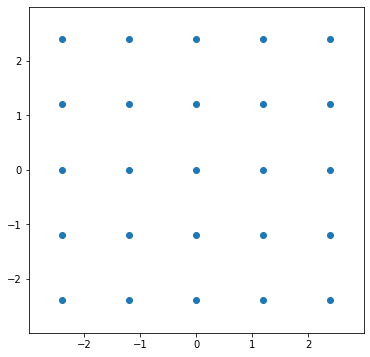

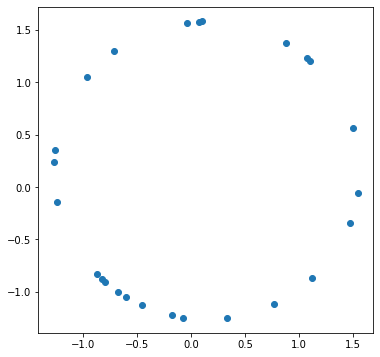

In [374]:
x,y,vx,vy = create_initial(N)

plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(vx,vy)
plt.show()

In [375]:
@njit
def verlet_list(x, y):
    N = len(x)
    global r_v
    r2_v = r_v*r_v
    
    n_viz = np.zeros(N, dtype=np.int64)             # número de vizinhos por partícula
    viz = np.full(N*(N-1), -1, dtype=np.int64)      # os n_viz[i] vizinhos listados
    
    count = 0
    for i in range(N):                              # loop sobre todas as partículas
        for j in range(N):                          # loop sobre todos os possíveis vizinhos
            dist = distance(x[i], y[i], x[j], y[j])[0]
            dist2 = dist*dist
            if dist2 <= r2_v and dist != 0: 
                viz[count] = j
                count += 1
                n_viz[i] += 1
    
    viz_2 = np.empty(count, dtype=np.int64)
    for i in range(count):
        viz_2[i] = viz[i]
    
    return n_viz, viz_2

In [376]:
a,b = verlet_list(x,y)
print(a)
print(b)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20]
[ 1  2  3  4  5  6  7  8  9 10 11 14 15 16 19 20 21 22 23 24  0  2  3  4
  5  6  7  8  9 10 11 12 15 16 17 20 21 22 23 24  0  1  3  4  5  6  7  8
  9 11 12 13 16 17 18 20 21 22 23 24  0  1  2  4  5  6  7  8  9 12 13 14
 17 18 19 20 21 22 23 24  0  1  2  3  5  6  7  8  9 10 13 14 15 18 19 20
 21 22 23 24  0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 19 20 21 24
  0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 20 21 22  0  1  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 21 22 23  0  1  2  3  4  5  6  7
  9 10 11 12 13 14 17 18 19 22 23 24  0  1  2  3  4  5  6  7  8 10 11 12
 13 14 15 18 19 20 23 24  0  1  4  5  6  7  8  9 11 12 13 14 15 16 17 18
 19 20 21 24  0  1  2  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22
  1  2  3  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 23  2  3  4  5
  6  7  8  9 10 11 12 14 15 16 17 18 19 22 23 24  0  3  4  5  6  7  8  9
 10 11 12 13 15 16 17 18 19 20 23 24  0  1  4 

In [377]:
@njit
def lennard_jones_energy(dist):
    global r_c
    epsilon = 0.1
    sigma = 1
    
    if dist <= r_c:
        res = 4*epsilon*((np.power(sigma/dist,12) - np.power(sigma/dist,6)) - (np.power(sigma/r_c,12) - np.power(sigma/r_c,6)))  
    
    else:
        res = 0
        
    return res

In [378]:
@njit
def lennard_jones_force(dist):
    global r_c
    epsilon = 0.1
    sigma = 1
    
    if dist <= r_c:
        res = (48*epsilon/(sigma*sigma)) * (np.power(sigma/dist,14) - 1/2 * np.power(sigma/dist,8))
        
    else:
        res = 0
        
    return res

In [379]:
@njit
def calculate_force(x, y, i, j):
    # calcula a força que j faz em i
    N = len(x)
    
    force = np.zeros(2)
    
    dist, x_ij, y_ij = distance(x[i],y[i],x[j],y[j])
    
    force_mod = lennard_jones_force(dist)
    
    force[0] = force_mod * x_ij  
    force[1] = force_mod * y_ij
    
    return force

In [380]:
@njit
def calculate_energy(x, y, vx, vy):
    N = len(x)
    global limite_de_aproximacao
    energia = 0 
    overlap = 0
    maior_velocidade = 0
    
    for i in range(N):
        energia += 1/2 * (vx[i]*vx[i] + vy[i]*vy[i])
        if (vx[i]*vx[i] + vy[i]*vy[i]) > maior_velocidade:
            maior_velocidade = np.sqrt(vx[i]*vx[i] + vy[i]*vy[i])
            
        for j in range(i+1,N):
            dist = distance(x[i],y[i],x[j],y[j])[0]
            if dist <= limite_de_aproximacao:
                overlap = 1
            energia += lennard_jones_energy(dist)
            
    return energia, overlap, maior_velocidade

In [381]:
@njit 
def calculate_forces(x,y,n_viz,viz):
    N = len(x)
    forces = np.zeros((N,2))

    for i in range(N):
        for j in range(int(sum(n_viz[:i])),int(sum(n_viz[:i+1]))):
            forces[i] += calculate_force(x,y,i,viz[j])
        
    return forces

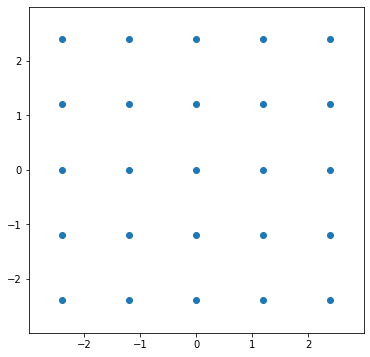

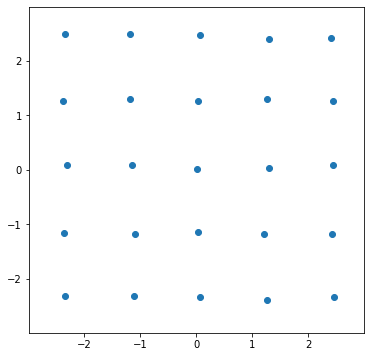

[[ 0.04038915 -0.10006184]
 [ 0.03459418  0.10918519]
 [-0.08144913 -0.02799297]
 [ 0.06468458  0.05235713]
 [-0.08115746 -0.03896093]
 [-0.02915831 -0.09475287]
 [-0.17039612  0.14744248]
 [-0.02770464 -0.01284833]
 [ 0.00114729 -0.01409092]
 [ 0.08261831 -0.02267847]
 [ 0.00206769  0.06064424]
 [ 0.13017397 -0.05783065]
 [ 0.09222953  0.0503899 ]
 [ 0.00471893 -0.00707596]
 [ 0.00401115 -0.04855959]
 [-0.0018833   0.0134569 ]
 [ 0.03833748 -0.01236703]
 [-0.12239282  0.00462626]
 [-0.02014899 -0.26918754]
 [-0.26134772  0.25773741]
 [-0.00664521 -0.12536262]
 [-0.03041842  0.10695881]
 [ 0.135384   -0.03310058]
 [-0.05394206 -0.04626024]
 [ 0.25628789  0.10833222]]


In [382]:
x,y,vx,vy = create_initial(N)
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()

for i in range(len(x)):
    x[i] += rd.random()*0.1
    y[i] += rd.random()*0.1
    
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()

n_viz, viz = verlet_list(x, y)

#print(n_viz,viz)
print(calculate_forces(x,y,n_viz,viz))

In [383]:
@njit
def simulate(x, y, vx, vy, n_viz, viz, forces, passo, maior_velocidade, last, dt = 0.001):
    
    N = len(x)
    energia = 0
    global r_v, r_c
    
    # calcula a lista de vizinhos (condição: à cada x passos (tem que mudar segundo a teoria))
    if 2*maior_velocidade*dt*(passo-last) >= r_v - r_c:
        n_viz, viz = verlet_list(x, y)
        last = passo

    # calcula a força entre as partículas
    forces = calculate_forces(x,y,n_viz,viz)
            
    # evolui as posições e velocidades

    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
    # evolui os valores das posições
    for i in range(N):
        x[i] = x[i] + vx[i]*dt
        
        # move uma partícula para dentro da caixa caso ela saia (como em Pacman)
        if x[i] >= box_size/2:
            x[i] -= box_size
        elif x[i] < -box_size/2:
            x[i] += box_size
            
        y[i] = y[i] + vy[i]*dt
        
        # move uma partícula para dentro da caixa caso ela saia (como em Pacman)
        if y[i] >= box_size/2:
            y[i] -= box_size
        elif y[i] < -box_size/2:
            y[i] += box_size

    # calcula a força entre as partículas
    forces = calculate_forces(x,y,n_viz,viz)
    
    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
        
    dados = calculate_energy(x,y,vx,vy)
    energia += dados[0]
    overlap = dados[1]
    maior_velocidade = dados[2]
    
    return x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last

In [388]:
passos = 100000
dt = 0.001
energias = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)
plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()


dados = calculate_energy(x,y,vx,vy)
energias[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias[i] = energia
    if overlap:
        print("parou")
        break
    if i%50== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias[:i])
plt.show()

SystemError: CPUDispatcher(<function simulate at 0x0000025A6EE553A8>) returned a result with an error set

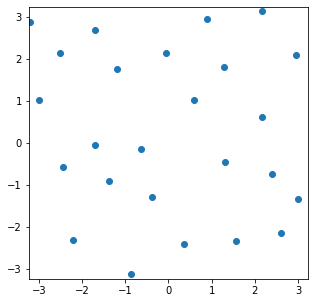

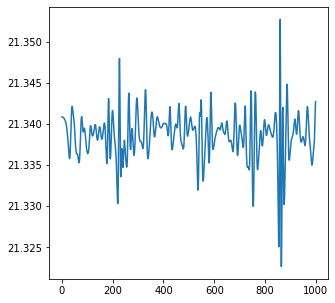

In [278]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)
xs0 = np.zeros((passos,N))
ys0 = np.zeros((passos,N))

xs0[0] = x
ys0[0] = y

dados = calculate_energy(x,y,vx,vy)
energias[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias[i] = energia
    if overlap:
        break
    xs0[i] = x
    ys0[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

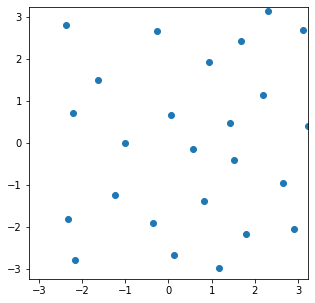

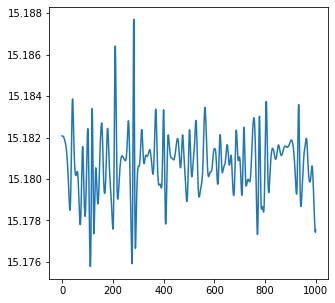

In [279]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)
xs1 = np.zeros((passos,N))
ys1 = np.zeros((passos,N))

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-9
    y[i] += (rd.random() - 1/2) * 10e-9


xs1[0] = x
ys1[0] = y

dados = calculate_energy(x,y,vx,vy)
energias[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias[i] = energia
    if overlap:
        break
    xs1[i] = x
    ys1[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

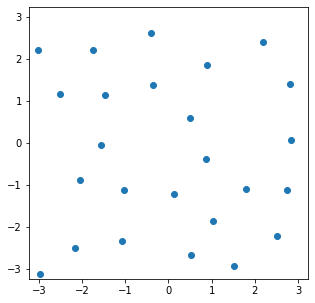

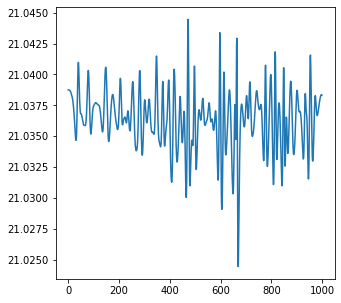

In [240]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)
xs2 = np.zeros((passos,N))
ys2 = np.zeros((passos,N))

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-6
    y[i] += (rd.random() - 1/2) * 10e-6


xs2[0] = x
ys2[0] = y

dados = calculate_energy(x,y,vx,vy)
energias[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias[i] = energia
    if overlap:
        break
    xs2[i] = x
    ys2[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

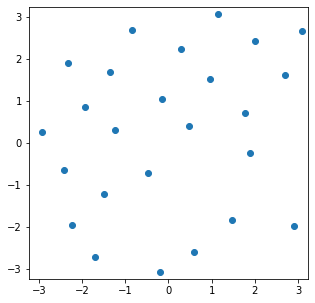

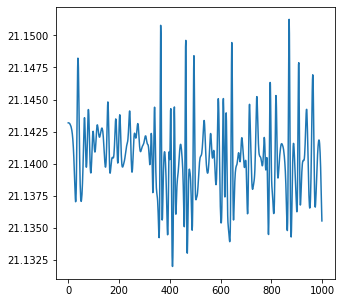

In [280]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)
xs3 = np.zeros((passos,N))
ys3 = np.zeros((passos,N))

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-9
    y[i] += (rd.random() - 1/2) * 10e-9


xs3[0] = x
ys3[0] = y

dados = calculate_energy(x,y,vx,vy)
energias[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias[i] = energia
    if overlap:
        break
    xs3[i] = x
    ys3[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

In [281]:
delta_r2_1 = np.zeros(passos) 
delta_r2_2 = np.zeros(passos)
delta_r2_3 = np.zeros(passos) 
aux1=0
aux2=0
aux3=0

for i in range(passos):
    for j in range(N):
        aux1 += (xs1[i][j] - xs0[i][j]) * (xs1[i][j] - xs0[i][j]) + (ys1[i][j] - ys0[i][j]) * (ys1[i][j] - ys0[i][j])
        aux2 += (xs2[i][j] - xs0[i][j]) * (xs2[i][j] - xs0[i][j]) + (ys2[i][j] - ys0[i][j]) * (ys2[i][j] - ys0[i][j])
        aux3 += (xs3[i][j] - xs0[i][j]) * (xs3[i][j] - xs0[i][j]) + (ys3[i][j] - ys0[i][j]) * (ys3[i][j] - ys0[i][j])
    aux1 = aux1/N
    aux2 = aux2/N
    aux3 = aux3/N
    delta_r2_1[i] = aux1
    delta_r2_2[i] = aux2
    delta_r2_3[i] = aux3

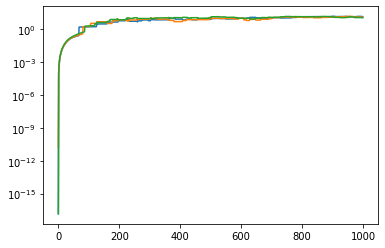

In [282]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.plot(delta_r2_1)
ax.plot(delta_r2_2)
ax.plot(delta_r2_3)

As pequenas diferenças das trajetórias das partículas aumentam conforme a simulação evolui para todas as perturbações. Nos mostrando o comportamento caótico do sistema, em que pequenas pertubações nas posições iniciais, da ordem de 10^-9, ocasionam em trajetórias completamente distintas.

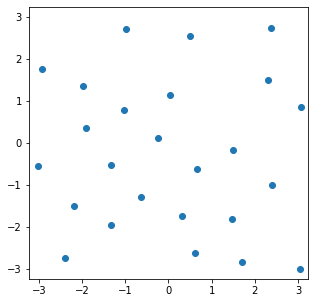

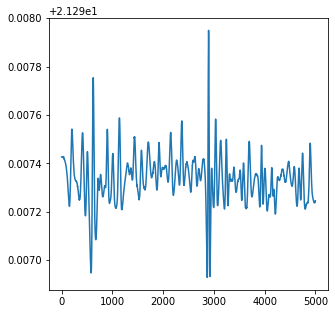

In [283]:
t = 5
dt = 10e-4
passos = int(t/dt)
energias_4 = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)

dados = calculate_energy(x,y,vx,vy)
energias_4[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias_4[i] = energia
    if overlap:
        break
    """if i%100 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_4)
plt.show()

In [284]:
media_energia = sum(energias_4)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_4[i]-media_energia)*(energias_4[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

21.29733679506653 9.956296832430149e-05


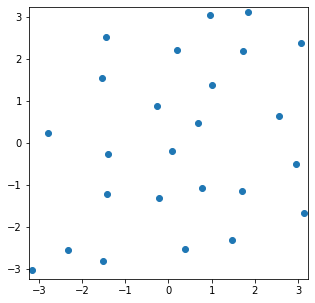

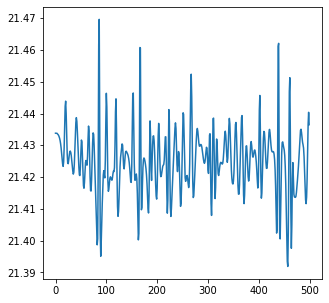

In [285]:
t = 5
dt = 10e-3
passos = int(t/dt)
energias_3 = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)

dados = calculate_energy(x,y,vx,vy)
energias_3[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias_3[i] = energia
    if overlap:
        break
    """if i%100 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_3)
plt.show()

In [286]:
media_energia = sum(energias_3)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_3[i]-media_energia)*(energias_3[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

21.42505272655914 0.01005546678349848


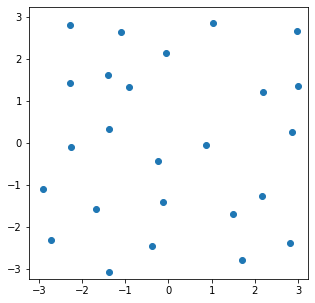

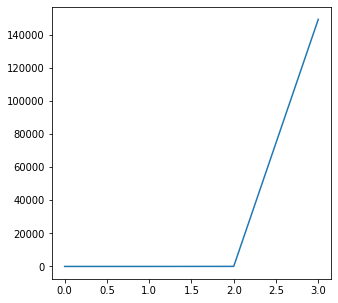

In [308]:
t = 5
dt = 10e-2
passos = int(t/dt)
energias_2 = np.zeros(passos)
forces = np.zeros((N,2))

last = 0

x,y,vx,vy = create_initial(N)

dados = calculate_energy(x,y,vx,vy)
energias_2[0] = dados[0]
maior_velocidade = dados[2]

n_viz, viz = verlet_list(x, y)

forces = calculate_forces(x,y,n_viz,viz)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia, overlap, maior_velocidade, last = simulate(x,y,vx, vy,n_viz, viz, forces, i, maior_velocidade, last, dt)
    energias_2[i] = energia
    if overlap:
        break
    if i%1 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_2[:i+1])
plt.show()

In [309]:
media_energia = sum(energias_2)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_2[i]-media_energia)*(energias_2[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

2988.8200220848626 21119.963138955263


Os valores dos pequenos passos temporais são de suma importância para uma boa simulação. A energia não é conservada para maiores valores de dt, e varia menos ao longo da simulação se dt é pequeno. 